# Airfoil contour analysis

This <font face="Verdana" size=4>**IP</font><font color='#578AC0' size=4>[</font><font color='black' size=4>y</font><font color='#578AC0' size=4>]: Notebook**</font> illustrates how to use Python, Numpy and Matplotlib in order to analyze airfoil contour data.
The airfoil used for demonstration is MH32 from Martin Hepperle.  
The MH32 airfoil is widely used for RC model airplanes. Its main area of usage is F3B and F5B.
    
The script shows how to utilize these tools for following tasks:

* Contour refinement
* Calculate 1<sup>st</sup> derivative
* Calculate 2<sup>nd</sup> derivative (used to show smoothness of data)
* Plot contour and its derivatives

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.interpolate as spi
import scipy.linalg as sla

import base64
from cStringIO import StringIO
import gzip
import copy

%matplotlib inline

In [3]:
# base64 encoded string representation of gzipped airfoil coordinate file
MH32_COMPRESSED = '''
H4sICIlqr1IC/21oMzJfY29udG91ci50eHQAZVM7jlRBDIx3TjHSiJCV/5+cgIRTIALE/XNc7p4E
Npmteu2yXbZfj9fzx3eVZ30mP788v/3++efX4/XgT8LfB53fB312R8rB6sCVFIvZ93uy+WINBfZ5
tzgygMVEgZnKBldr8GJPvC+vLmBhWSxUqy8jPDizc+NVuYE1yBY3I380cQKbRQKb+NZrncDe6vve
TQXYNA8uRby1nv6Cg4HNaOsLI+RTNLTYA/2rpa4/EQJ9JZY63wv9yrRlJ14RLzwNHv1Gfs48/ngZ
+mOTo+/aBczE+95q6yEYslgM+cmzt171gB5p1sZLCfKNj30wrR/ju6yfrAR9moerT96r98+88Z0/
vuIfOwmY8xJVS8hYtwRLboj5SCwxswExQ4lD1A6ZOm+IUG7XyveFTJ0goiwvkehbqKPfhK2xM8BL
7KaM81WHYIGGOpedtN0729nJdx0CDfO4WTgUhPP4fAhb++aBXEIYosHpt7lZcRDRfuqgWU1sJPfb
oCBYmpEW10LdnR6tIzrmxi69ymluCum9CpJj0LgsezZy007M3pF12J2TnruTc2dT6b1Lvpjv3b7n
6v/d9V9zm9bCAAQAAA=='''

In [4]:
# decode and unzip
unzipped = gzip.GzipFile(mode='rb', fileobj=StringIO(base64.b64decode(MH32_COMPRESSED)))

In [5]:
# read data from file object
data = unzipped.read()

In [6]:
lines = data.split('\n')

In [7]:
# this should be refactored
lines = data.split('\n')
x = [float(line.split('\t')[0]) for line in lines if (line.find('#') == -1 and len(line.split()) == 2)]
y = [float(line.split('\t')[1]) for line in lines if (line.find('#') == -1 and len(line.split()) == 2)]

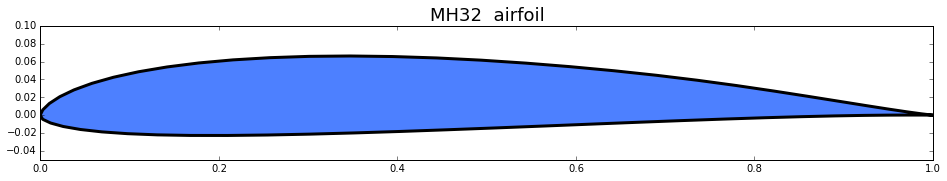

In [8]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y, 'k', linewidth=3)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.05, 0.1)
ax.set_title('MH32  airfoil', fontsize=18)
ax.fill(x, y, color=(0.3, 0.5, 1))
ax.set_aspect('equal')

In [9]:
def refine(xo, yo, tol=170.0):
    """Recursive refinement with respect to angle criterion (tol)"""

    x = copy.deepcopy(xo)
    y = copy.deepcopy(yo)
    
    # get knots of spline
    # "tck" used later sin "splev" to insert new points on splined "old" geometry
    coo, u, t, der1, der2, tck = spline(xo, yo, 300, False)

    for i in range(len(x)-2):
        a = np.array([x[i] - x[i+1], y[i] - y[i+1]])
        b = np.array([x[i+2] - x[i+1], y[i+2] - y[i+1]])
        ang = angle_degree(a, b)
        if ang < tol:
            # 
            p1 = spi.splev((u[i+1]+u[i])/2, tck, der=0)
            p2 = spi.splev((u[i+2]+u[i+1])/2, tck, der=0)
            x.insert(i+1, p1[0])
            y.insert(i+1, p1[1])
            x.insert(i+3, p2[0])
            y.insert(i+3, p2[1])
            return refine(x, y, tol)
    return x, y

In [10]:
def spline(x, y, num=200, ev=False):
    """Interpolate spline through given points"""

    # interpolate B-spline through data points
    # returns knots of B-spline ontrol polygon
    # tck ... tuple (t,c,k) containing the vector of knots, the B-spline coefficients, and the degree of the spline.
    # u ... array of the parameters; defines parameter for given points on the spline
    tck, u = spi.splprep([x, y], s=0, k=4)

    # number of points on interpolated B-spline (parameter t)
    t = np.linspace(0.0, 1.0, num)
    # in this case spline is only evaluated at the points (x, y) instead of num points otherwise
    if ev:
        t = u

    # evaluate B-spline at given parameters (der=0: returns point coordinates)
    coo = spi.splev(t, tck, der=0)

    # evaluate 1st derivative at given parameters
    der1 = spi.splev(t, tck, der=1)

    # evaluate 2nd derivative at given parameters
    der2 = spi.splev(t, tck, der=2)

    return coo, u, t, der1, der2, tck

In [11]:
def angle_degree(a, b):
    """Return angle between two vectors"""
    dot = np.dot(a, b)
    na = sla.norm(a)
    nb = sla.norm(b)
    cosinus = dot / (na * nb)
    ang = np.arccos(cosinus)* 180.0 / np.pi

    return ang

In [12]:
xo = copy.deepcopy(x)
yo = copy.deepcopy(y)

# refine initial contour data with angle criterion
xn, yn = refine(xo, yo, 169.0)

# interpolate spline through refined contour polygon
coo, u, t, der1, der2, tck = spline(xn, yn, 601, False)

In [13]:
# der1 is dx/dt and dy/dt at each point
# der2 is d2x/dt2 and d2y/dt2 at each point

# gradient dy/dx = dy/du / dx/du
gradient = der1[1] / der1[0]

# radius of curvature for a parametric curve (B-spline in this case)
xd = der1[0]
yd = der1[1]
x2d = der2[0]
y2d = der2[1]
n = xd**2+ yd**2
d = xd*y2d-yd*x2d
# radius of curvature
R = n**(3./2.) / abs(d)
# curvature
C = d / n**(3./2.)
# coordinates of curvature-circle center points
xc = coo[0] - yd * n / d
yc = coo[1] - xd * n / d

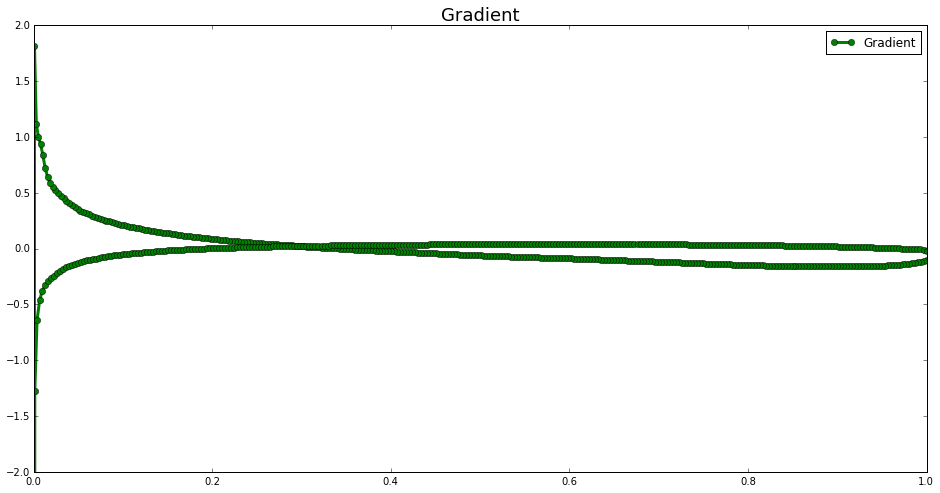

In [14]:
fig2 = plt.figure(figsize=(16, 8))
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(coo[0], gradient,'go-', label='Gradient', linewidth=3)
ax2.set_title('Gradient', fontsize=18)
ax2.set_xlim(0.0, 1)
ax2.set_ylim(-2., 2)
ax2.legend(loc='best')

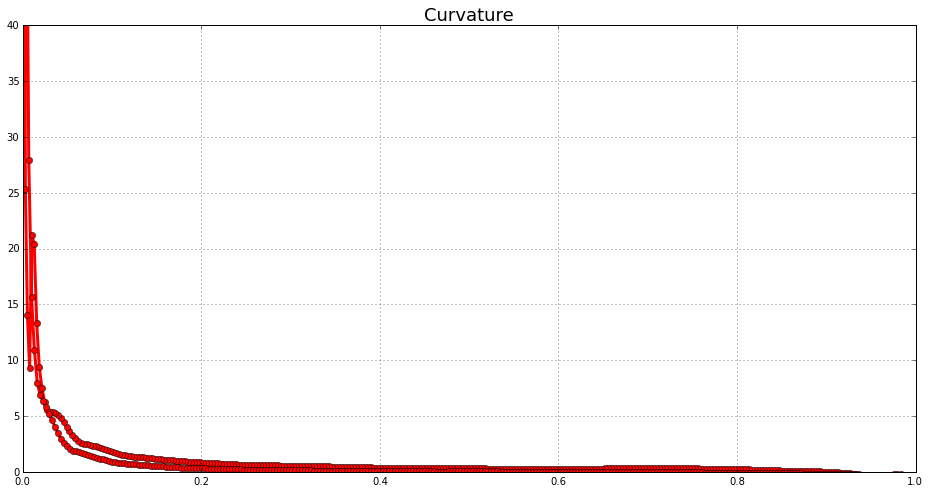

In [15]:
fig3 = plt.figure(figsize=(16, 8))
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(coo[0], C,'ro-', linewidth=3)
ax3.set_title('Curvature', fontsize=18)
ax3.set_xlim(0.0, 1.0)
ax3.set_ylim(0.0, 40.0)
ax3.grid()

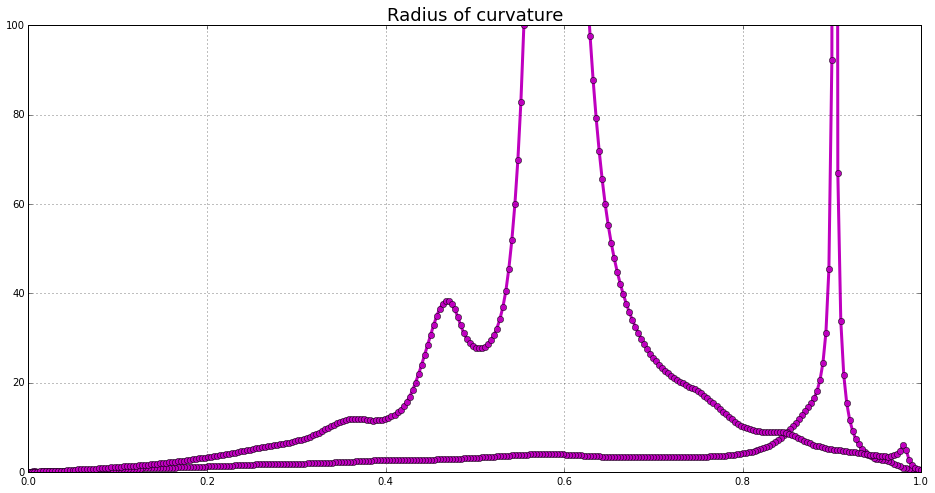

In [46]:
fig4 = plt.figure(figsize=(16, 8))
ax4 = fig4.add_subplot(1,1,1)
ax4.plot(coo[0], R,'mo-', linewidth=3)
ax4.set_title('Radius of curvature', fontsize=18)
ax4.set_xlim(0.0, 1.0)
ax4.set_ylim(0.0, 100.)
ax4.grid()
#ax4.set_aspect(1)

In [47]:
r = np.min(R)

In [48]:
mg1 = max(gradient)
img1 = np.where(gradient == mg1)
img = img1[0][0]+1
mg = gradient[img]
print img, img1
print mg, mg1
xg = coo[0][img]
yg = coo[1][img]

def sl(x, px, py, k):
    d = py - px*k
    y = k*x + d
    return y
ys1 = sl(1, xg, yg, mg)
ys2 = sl(-1, xg, yg, mg)
vx = mg
vy = -1.0
vl = np.sqrt(vx**2+vy**2)
xr = xg - vx / vl * r
yr = yg - vy / vl * r

302 (array([301]),)
-38.8413692879 1.81113404749


In [49]:
circle = patches.Circle( (xr, yr) , r, edgecolor='y', facecolor='None', linewidth=3, zorder=10, ls='solid')

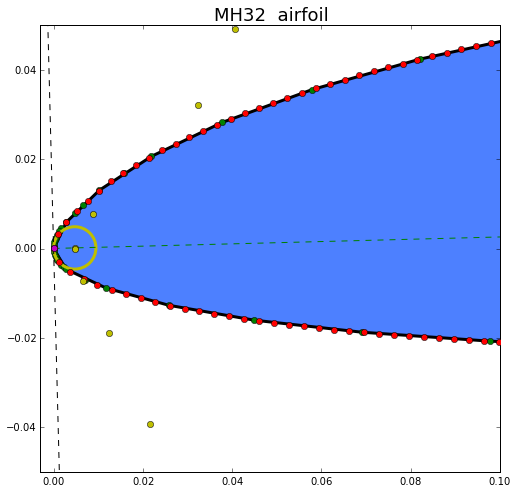

In [50]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y, 'k', linewidth=3)
ax.plot(coo[0], coo[1], 'ro', zorder=20)
ax.plot(xn, yn, 'go')
ax.plot(xr, yr, 'yo', zorder=11)
ax.plot(xc, yc, 'yo', zorder=40)
ax.plot(xg, yg, 'mo', zorder=30)
ax.plot([1., -1], [ys1, ys2], 'k--', zorder=10)
ax.plot([xg, -mg], [yg, 1.], 'g--', zorder=10)
ax.add_patch(circle)
ax.set_xlim(-0.003, .1)
ax.set_ylim(-0.05, 0.05)
ax.set_title('MH32  airfoil', fontsize=18)
ax.fill(x, y, color=(0.3, 0.5, 1))
ax.set_aspect('equal')

In [51]:
r

0.0047429701321863383